<h1><center><font size="6">Classification</font></center></h1>



In your second homework you need to create a model that predicts which passengers survived the Titanic shipwreck.

In [38]:
import pandas as pd
import numpy as np
import datetime
import sys
import os
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn import metrics
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import miceforest as mf
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

In [39]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# <a id='3'>Data exploration</a>  

We check the shape of train and test dataframes and also show a selection of rows, to have an initial understanding of the data.



In [40]:
train_df.sample(5).head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
219,220,0,2,"Harris, Mr. Walter",male,30.0,0,0,W/C 14208,10.5000,NaN,S
576,577,1,2,"Garside, Miss. Ethel",female,34.0,0,0,243880,13.0000,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
671,672,0,1,"Davidson, Mr. Thornton",male,31.0,1,0,F.C. 12750,52.0000,B71,S
656,657,0,3,"Radeff, Mr. Alexander",male,NaN,0,0,349223,7.8958,NaN,S


In [41]:
print("Train: rows:{} cols:{}".format(train_df.shape[0], train_df.shape[1]))
print("Test:  rows:{} cols:{}".format(test_df.shape[0], test_df.shape[1]))

Train: rows:891 cols:12
Test:  rows:418 cols:11


Both **train** and **test** files contains the following values:  

* **PassengerID** - the index of the passenger (in the dataset);  
* **PClass** - the class of the passenger (from 1 to 3);
* **Name** - the name of the passenger;
* **Sex** - the sex of the passenger (female or male);  
* **Age** - the age (where available) of the passenger;  
* **SibSp** - the number of sibilings / spouses aboard of Titanic;  
* **Parch** - the number of parents / children aboard of Titanic;  
* **Ticket** - the ticket number;  
* **Fare** - the passenger fare (ticket cost);  
* **Cabin** - the cabin number;  
* **Embarked** - the place of embarcation of the passenger (C = Cherbourg, Q = Queenstown, S = Southampton).  

The **train** data has as well the target value, **Survived**.

It is important to have a good understanding of the data before going to create a model. Therefore we will explore the features.

Let's start by checking if there are missing data and unlabeled data.

Next, analyze the dependencies of the target variable on various features, such as Age, Sex, and so on, using approaches similar to those in the first homework.

Draw conclusions about what affects whether the passenger survives, check the distribution of features in the train and test data. 

## Checking dtypes, N/A data
Let's see the datatypes, missing data and unique values for each feature.

In [42]:
train_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [43]:
data_observ = pd.DataFrame({
    col: (
        train_df[col].unique(),
        len(train_df[col].unique()),
    )
    for col in train_df
}).T
data_observ.columns = ['Unique values', 'Num of unique values']
data_observ['Num of NaN'] = train_df.isna().sum()
data_observ

,Unique values,Num of unique values,Num of NaN
PassengerId,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",891,0
Survived,"[0, 1]",2,0
Pclass,"[3, 1, 2]",3,0
Name,"[Braund, Mr. Owen Harris, Cumings, Mrs. John B...",891,0
Sex,"[male, female]",2,0
Age,"[22.0, 38.0, 26.0, 35.0, nan, 54.0, 2.0, 27.0,...",89,177
SibSp,"[1, 0, 3, 4, 2, 5, 8]",7,0
Parch,"[0, 1, 2, 5, 3, 4, 6]",7,0
Ticket,"[A/5 21171, PC 17599, STON/O2. 3101282, 113803...",681,0
Fare,"[7.25, 71.2833, 7.925, 53.1, 8.05, 8.4583, 51....",248,0


Out of all features we have **name**, **Sex**, **Ticket**, **Cabin**, **Embarked** as categorical data and other features are numerical or categorical but already tranformed to numerical, like **Pclass**,  **SibSp**, **Parch**. We have missing values in features **Age**, **Cabin**, **Embarked**.  
Firstly, let's handle the missing values:
+ for **Embarked** I would prefer to replace NaN values with most frequend value.
+ for **Cabin** we have 687 missing values out of 891, it's more than a half, so I would prefer to exclude this feature in future analyzis as I believe it is not informative.
+ for **Age** I would use Multiple Imputation by Chained Equations (MICE) with LightGBM. It gives an opportunity to replace missing values with different values, taking into account other features. We have almost 20% missing values for this feature so it would be incorrect to replace it with fixed value as we can spoil age distribution.

### Lets explore some features dependencies in train:
#### *Survived* feature:

In [44]:
target = 'Survived'

def count_and_percentage(data, feature):
    print('Feature', feature)
    for value in data[feature].unique():
        count_ = data.loc[data[feature] == value][feature].count()
        print("Count of {}: {}".format(value, count_))
        print("Percentage of {} among all people: {}".format(value,
                                            count_ / data.shape[0] * 100))


count_and_percentage(train_df, target)

Feature Survived
Count of 0: 549
Percentage of 0 among all people: 61.61616161616161
Count of 1: 342
Percentage of 1 among all people: 38.38383838383838


In train dataset percentage of survived is ~ 38%, not survived ~ 61%, so we can see that classes are **not balanced**.
#### *Sex* feature:

In [45]:
print('For train data: ')
count_and_percentage(train_df, 'Sex')
print()
print('For test data: ')
count_and_percentage(test_df, 'Sex')

For train data: 
Feature Sex
Count of male: 577
Percentage of male among all people: 64.75869809203144
Count of female: 314
Percentage of female among all people: 35.24130190796858

For test data: 
Feature Sex
Count of male: 266
Percentage of male among all people: 63.63636363636363
Count of female: 152
Percentage of female among all people: 36.36363636363637


In both train and test dataset percentage of women ~ 35%, percentage of men ~ 64-65%.

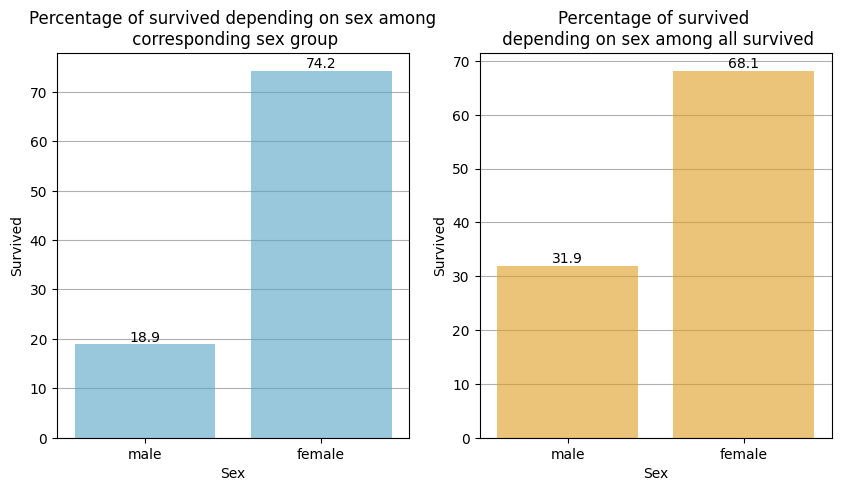

In [46]:
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams['axes.axisbelow'] = True
fig, ax = plt.subplots(ncols=2)


def plot_survived_feature(
        data,
        feature,
        ax,
        estimator=lambda x: round(sum(x == 1) * 100.0 / len(x), 1),
        color= (0.26, 0.67, 0.85)):
    sns.barplot(x=feature,
                y=target,
                data=data,
                estimator=estimator,
                errorbar=None,
                alpha=0.6,
                ax=ax,
                color=color)
    ax.bar_label(ax.containers[0])
    ax.grid(axis='y')

survived_num = train_df.loc[train_df[target] == 1].shape[0]
estimator = lambda x: round(sum(x == 1) * 100.0 / survived_num, 1)
plot_survived_feature(train_df, 'Sex', ax[0])
plot_survived_feature(train_df, 'Sex', ax[1], estimator, color = 'orange')

ax[0].set_title('Percentage of survived depending on sex among\n corresponding sex group')
_ = ax[1].set_title('Percentage of survived \n depending on sex among all survived')

74% women and 19% men survived. 68% of survived were women and 31% - men, even though amount of men were ~2 times bigger than amount of women.

#### *Age* feature

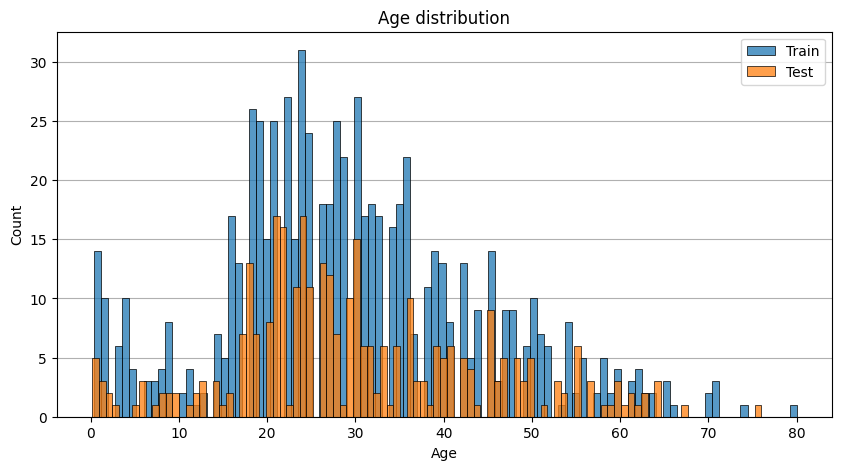

In [47]:
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams['axes.axisbelow'] = True
plt.grid(axis='y')
sns.histplot(data=train_df, x='Age', bins=100)
sns.histplot(data=test_df, x='Age', bins=100)
plt.legend(labels=['Train', 'Test'])
_ = plt.title('Age distribution')

We can see that both in train and test dataset the majority of people were young people from 18 to 35.

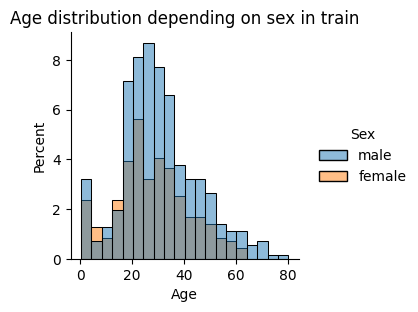

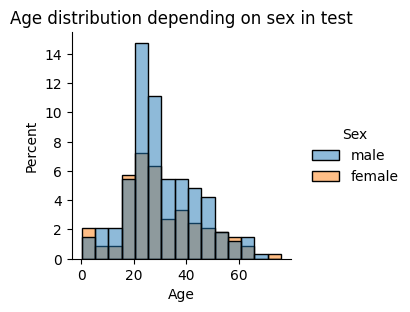

In [48]:
sns.displot(data=train_df, x='Age', stat='percent', hue='Sex', height=3)
plt.title('Age distribution depending on sex in train')
sns.displot(data=test_df, x='Age', stat='percent', hue='Sex', height=3)
_ = plt.title('Age distribution depending on sex in test')

Here we can see similar age distributions on train and test dataset for both women and man (in percentages).  
Now lets check surviving percentages among age groups united for 2 years (0-2, 3-4, ...25-26, ...)

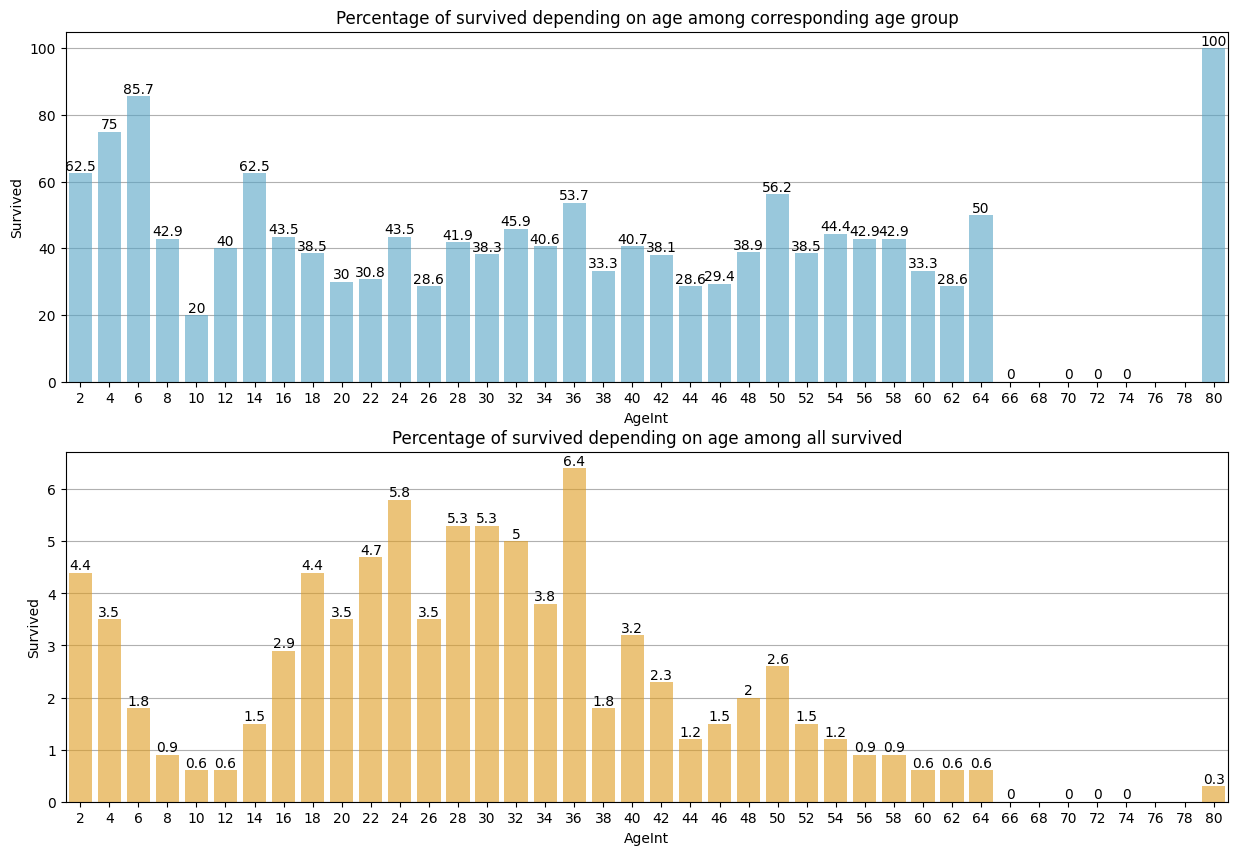

In [49]:
train_df_interval_age = train_df.copy()
bins = [x for x in range(0, 82, 2)]
train_df_interval_age['AgeInt'] = pd.cut(train_df.sort_values('Age')['Age'],
                                         labels=bins[1:],
                                         bins=bins,
                                         ordered=True)

plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams['axes.axisbelow'] = True
fig, ax = plt.subplots(nrows = 2) 
survived_num = train_df_interval_age.loc[train_df_interval_age[target] == 1].shape[0]
estimator = lambda x: round(sum(x == 1) * 100.0 / survived_num, 1)
plot_survived_feature(train_df_interval_age, 'AgeInt', ax[0])
plot_survived_feature(train_df_interval_age, 'AgeInt', ax[1], estimator, color = 'orange')
ax[0].set_title('Percentage of survived depending on age among corresponding age group')
_ = ax[1].set_title('Percentage of survived depending on age among all survived')

On first plot we can see that highest rates of survivence we can observe on ages 5-6, 13-14, 35-36, 49-50, 79-80 among their age group.  
From the second graph we can conclude that among survived the highest rates were for age groups 23-24 and 35-36 with 5.8% and 6.4% correspondingly.
Now let'see the same graphic but with gender proportion:

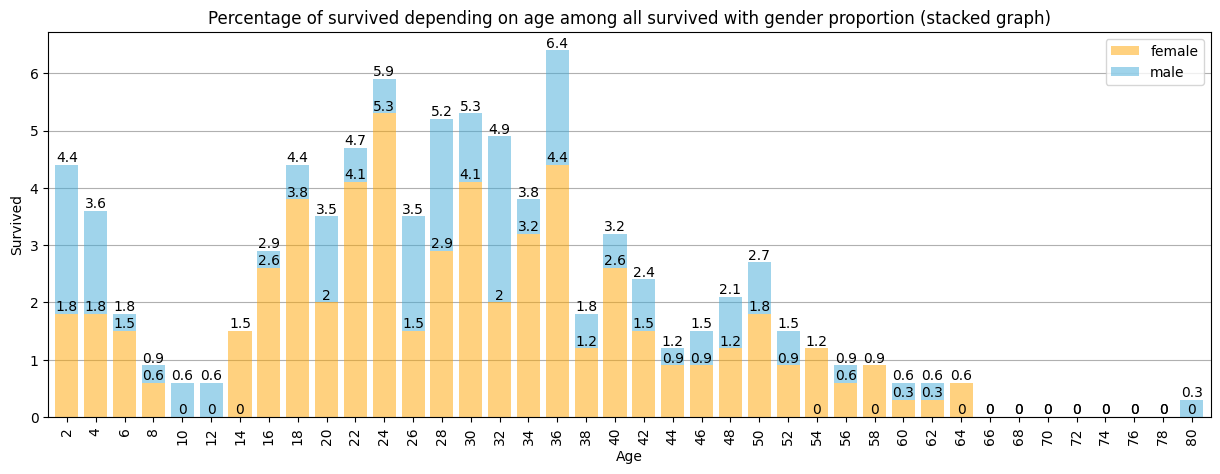

In [50]:
plt.rcParams["figure.figsize"] = (15, 5)
plt.rcParams['axes.axisbelow'] = True

df_= train_df_interval_age[[target, 'Sex', 'AgeInt']].copy()
df_= df_.loc[df_[target] == 1]
df_= df_.drop(target, axis = 1)
df_ = df_.groupby(by=['AgeInt', 'Sex'], observed=False)['Sex'].count().to_frame()
df_.columns = ['count']
df_to_plot = pd.DataFrame(columns=['female', 'male'], index=bins[1:])
for index, row in df_.iterrows():
    df_to_plot.loc[index[0]][index[1]] = round(row['count']*100/survived_num, 1)
colors = ['orange', (0.26, 0.67, 0.85)]
ax = df_to_plot.plot(kind='bar', stacked=True, color=colors, alpha = 0.5, width = 0.8)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.grid(axis='y')
ax.set_title('Percentage of survived depending on age among all survived with gender proportion (stacked graph)')
ax.set_xlabel('Age')
_= ax.set_ylabel('Survived')

Here we can see that people of age 3-4, 27-28 almost equal percentages for men and women among all survived. Proportion of women exceds men proportion for almost all ages as expected from previous analysis, expect for 0-2, 31-32, 9-12.

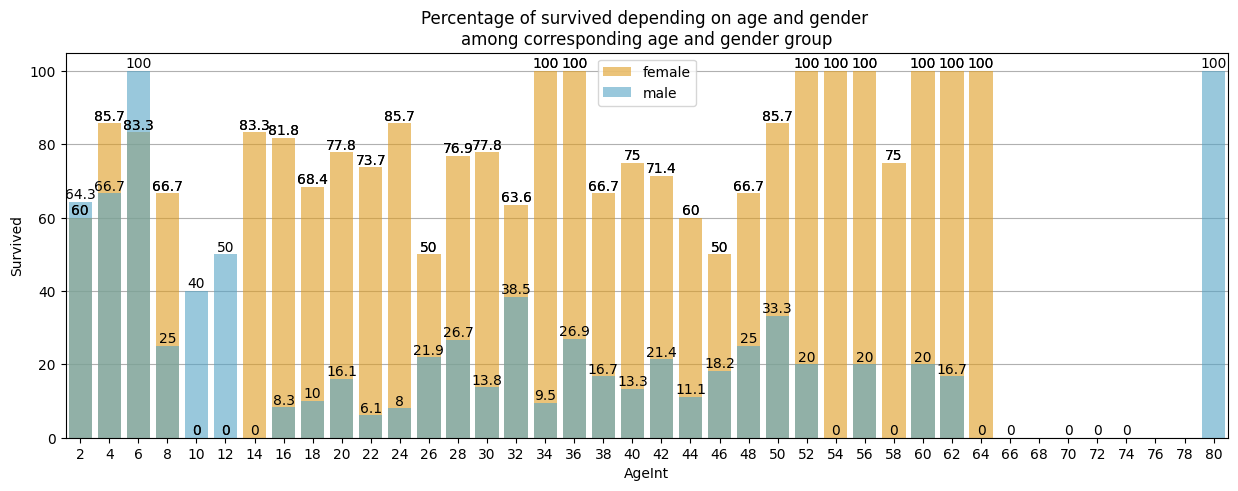

In [51]:
plt.rcParams["figure.figsize"] = (15, 5)
plt.rcParams['axes.axisbelow'] = True
fig, ax = plt.subplots() 
ax.grid(axis='y')
plot_survived_feature(
    train_df_interval_age.loc[train_df_interval_age['Sex'] == 'female'],
    'AgeInt', ax, color = 'orange')
plot_survived_feature(
    train_df_interval_age.loc[train_df_interval_age['Sex'] == 'male'],
    'AgeInt', ax)
_= ax.bar_label(ax.containers[1])
plt.legend(['female', 'male'])
_ = plt.title('Percentage of survived depending on age and gender \namong corresponding age and gender group')

This graph shows that all women of age 31-36, 51-56, 59-64 survived. Also all men of age 5-6, 79-80 survived. None of girls from 9-12 survived.  
Now let's see empty values:

In [52]:
age_NaN = train_df.loc[train_df['Age'].isna() == True]
survived = train_df.loc[(train_df['Age'].isna() == True)
                        & (train_df['Survived'] == 1)]
print("Percentage of survived with age NaN: {}".format(survived.shape[0] /
                                                       age_NaN.shape[0] * 100))
print("Percentage of survived women with age NaN: {}".format(
    survived[survived['Sex'] == 'female'].shape[0] /
    age_NaN[age_NaN['Sex'] == 'female'].shape[0] * 100))
print("Percentage of survived men with age NaN: {}".format(
    survived[survived['Sex'] == 'male'].shape[0] /
    age_NaN[age_NaN['Sex'] == 'male'].shape[0] * 100))

Percentage of survived with age NaN: 29.37853107344633
Percentage of survived women with age NaN: 67.9245283018868
Percentage of survived men with age NaN: 12.903225806451612


Those percentages reflects with overall trend.

#### *PClass* feature

In [53]:
print('For train data: ')
count_and_percentage(train_df.sort_values('Pclass'), 'Pclass')
print()
print('For test data: ')
count_and_percentage(test_df.sort_values('Pclass'), 'Pclass')

For train data: 
Feature Pclass
Count of 1: 216
Percentage of 1 among all people: 24.242424242424242
Count of 2: 184
Percentage of 2 among all people: 20.65095398428732
Count of 3: 491
Percentage of 3 among all people: 55.106621773288445

For test data: 
Feature Pclass
Count of 1: 107
Percentage of 1 among all people: 25.598086124401913
Count of 2: 93
Percentage of 2 among all people: 22.248803827751196
Count of 3: 218
Percentage of 3 among all people: 52.15311004784689


Both in test and train dataset the amount of people with class 3 dominated. Percentages for Pclasses are almost the same for each datasets correspondingly.

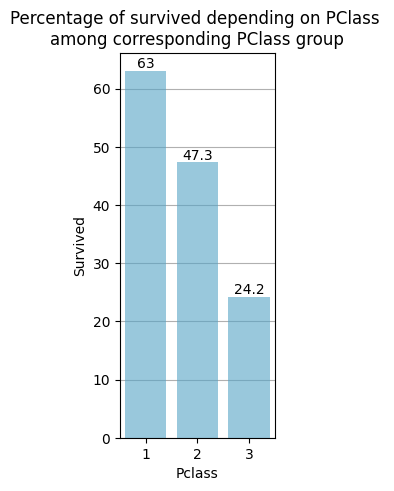

In [54]:
plt.rcParams["figure.figsize"] = (2, 5)
plt.rcParams['axes.axisbelow'] = True
fig, ax = plt.subplots() 
plot_survived_feature(train_df, 'Pclass', ax)
_ = plt.title('Percentage of survived depending on PClass \namong corresponding PClass group')

63% of people from 1st class survived, 47% of people from 2nd class survived and only 24% survived in 3d class.

#### *Fare* feature

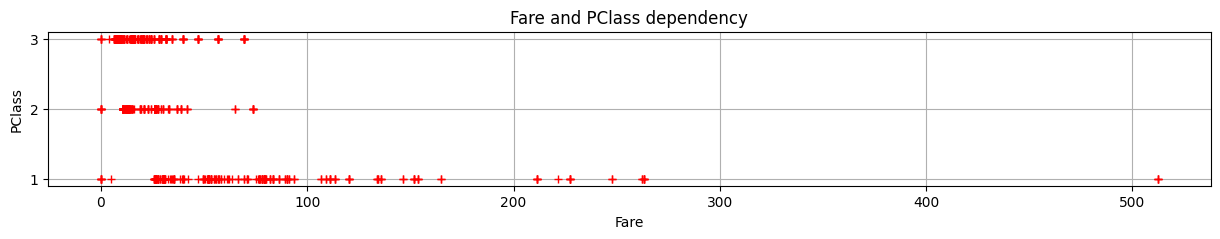

In [55]:
plt.rcParams["figure.figsize"] = (15, 2)
plt.rcParams['axes.axisbelow'] = True
plt.grid()
plt.plot(train_df['Fare'], train_df['Pclass'], 'r+')
plt.title('Fare and PClass dependency')
plt.xlabel('Fare')
plt.ylabel('PClass')
_ = plt.yticks(np.arange(1, 4))

There is not much correlation between Fare feature and PClass feature, although some 1st PClass tickets costed much more than the others.

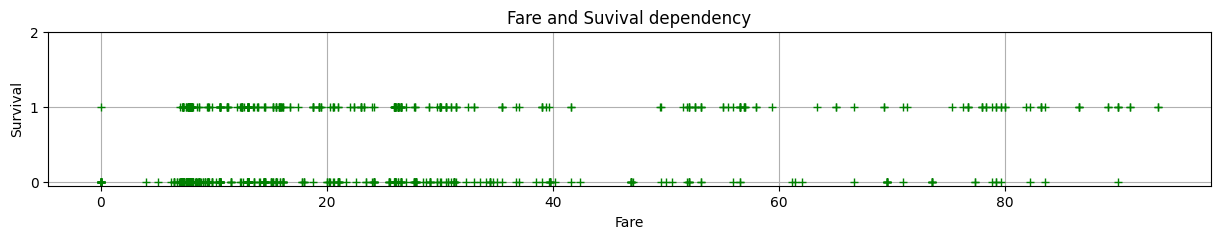

In [56]:
plt.rcParams["figure.figsize"] = (15, 2)
plt.rcParams['axes.axisbelow'] = True
plt.grid()
plt.plot(train_df.loc[train_df['Fare'] < 100]['Fare'],
         train_df.loc[train_df['Fare'] < 100][target], 'g+')
plt.title('Fare and Suvival dependency')
plt.xlabel('Fare')
plt.ylabel('Survival')
_ = plt.yticks(np.arange(0, 3))

Also can't see significant dependancy between Fare and Survival, though a lot more people with relatively cheap ticket did not survive.

#### *SibSP* and *Parch* features

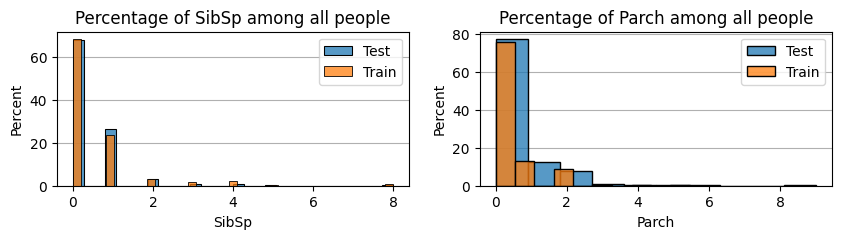

In [57]:
plt.rcParams["figure.figsize"] = (10, 2)
plt.rcParams['axes.axisbelow'] = True
fig, ax = plt.subplots(ncols=2)
ax[0].grid(axis='y')
sns.histplot(data=test_df, x='SibSp', ax=ax[0], stat='percent')
sns.histplot(data=train_df, x='SibSp', ax=ax[0], stat='percent')
ax[1].grid(axis='y')
sns.histplot(data=test_df, x='Parch', ax=ax[1], stat='percent')
sns.histplot(data=train_df, x='Parch', ax=ax[1], stat='percent')
ax[0].legend(labels=['Test', 'Train'])
ax[1].legend(labels=['Test', 'Train'])
ax[0].set_title('Percentage of SibSp among all people')
_ = ax[1].set_title('Percentage of Parch among all people')

For both datasets (train and test) the majority of people did not have relatives (both vertical/horizontal). 

#### *Embarked* feature

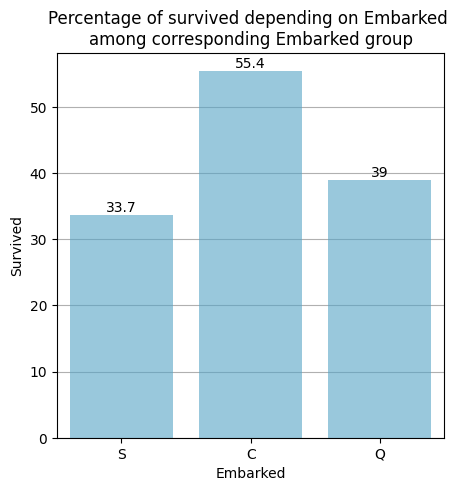

In [58]:
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams['axes.axisbelow'] = True
fig, ax = plt.subplots() 
plot_survived_feature(train_df, 'Embarked', ax)
_ = plt.title('Percentage of survived depending on Embarked \namong corresponding Embarked group')

### Encoding and handling missing values  
Dropping unnecessary features:

In [22]:
train_df = train_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
train_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,NaN,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


Replacing *Embarked* missing value with most frequent feature:

In [23]:
train_df['Embarked'] = train_df['Embarked'].replace(np.NaN, 'C')

Encoding features *Sex* and *Embarked* with label encoding:

In [24]:
categ = ['Sex', 'Embarked']
for cat in categ:
    l_e = LabelEncoder()
    l_e.fit(train_df[cat])
    train_df[cat] = l_e.transform(train_df[cat])
train_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2
...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000,2
887,1,1,0,19.0,0,0,30.0000,2
888,0,3,0,NaN,1,2,23.4500,2
889,1,1,1,26.0,0,0,30.0000,0


Using use Multiple Imputation by Chained Equations (MICE) with LightGBM to fill *Age* missing values

In [25]:
mice_kernel = mf.ImputationKernel(data=train_df,
                                  save_all_iterations=True,
                                  random_state=2023)

In [26]:
train_df = mice_kernel.complete_data()
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2



## <a id='50'>Split the data</a>  

Let's split the training and validation set. We will use a 80-20 split. Don't forget to fix random_state. 


In [27]:
#your code is here
y = train_df[target]
X_train, X_test, y_train, y_test = train_test_split(train_df[["Age", "Sex"]],
                                                    train_df[target],
                                                    test_size=0.2,
                                                    random_state=104)


## <a id='51'>Build a model</a>  

We will start with a simple model (baseline), with just two features, the `Sex` and `Pclass`. Create DesicionTreeClassifier and RandomForestClassifier, based on this features, without tuning parameters. 

Next, create two more complicated models: DesicionTreeClassifier and RandomForestClassifier with adding at least one feature you found useful as a result of your analysis.

Find accuracy score for all models. Is it a good idea to use accuracy? Any suggestions about metrics? 

Then try to tune at least one parameter for every model using grid search and write down features and parameters, which gave you best score. 

**Answer for accuracy**: We have imbalanced classes, amount of survived is almost 2 times less than unsurvived, so it not the best idea to judge models by accuracy only. It would be better to pay attention on **Precision** and **Recall** metrics too.

In [28]:
def simple_tree(classifier):
    tree_clf = classifier(random_state=104)
    tree_clf.fit(X_train, y_train)
    y_pred = tree_clf.predict(X_test)

    print('{} accuracy: {}'.format(tree_clf.__class__.__name__,
                                   accuracy_score(y_test, y_pred)))
    print('Classification Report')
    print(classification_report(y_test, y_pred))
    if (tree_clf.__class__.__name__ == 'DecisionTreeClassifier'):
        print('Feature importance: ')
        for i in range(len(X_train.columns)):
            print('{} - {}'.format(X_train.columns[i],
                                   tree_clf.feature_importances_[i]))
        print('Depth: {}, leaves number: {}'.format(tree_clf.get_depth(),
                                                    tree_clf.get_n_leaves()))
    else:
        print('Number of trees: {}'.format(tree_clf.n_estimators))

In [29]:
simple_tree(DecisionTreeClassifier)
print()
simple_tree(RandomForestClassifier)

DecisionTreeClassifier accuracy: 0.7374301675977654
Classification Report
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       123
           1       0.58      0.55      0.57        56

    accuracy                           0.74       179
   macro avg       0.69      0.69      0.69       179
weighted avg       0.73      0.74      0.74       179

Feature importance: 
Age - 0.3223605802299882
Sex - 0.6776394197700119
Depth: 19, leaves number: 109

RandomForestClassifier accuracy: 0.7486033519553073
Classification Report
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       123
           1       0.60      0.61      0.60        56

    accuracy                           0.75       179
   macro avg       0.71      0.71      0.71       179
weighted avg       0.75      0.75      0.75       179

Number of trees: 100


*DecisionTreeClassifier* is not working well with defining survived people. The metric for class 1 don't acceed 0.58 which is bad. The model payed more attention to feature Sex.  
*RandomForestClassifier* is doing a little better with defining surved people but it is also bad.  
Let's try to use more features:

In [30]:
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(target,
                                                                  axis=1),
                                                    train_df[target],
                                                    test_size=0.2,
                                                    random_state=104)

In [31]:
simple_tree(DecisionTreeClassifier)

DecisionTreeClassifier accuracy: 0.776536312849162
Classification Report
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       123
           1       0.63      0.70      0.66        56

    accuracy                           0.78       179
   macro avg       0.74      0.75      0.75       179
weighted avg       0.78      0.78      0.78       179

Feature importance: 
Pclass - 0.07457513485748524
Sex - 0.3239641997065331
Age - 0.24054998004696038
SibSp - 0.02148975596528976
Parch - 0.036707371095681667
Fare - 0.26597684233887403
Embarked - 0.036736715989175786
Depth: 18, leaves number: 160


Simple *DecisionTreeClassifier* with more features doing much better - it has higher accuracy and higher metrics for detecting survived people but it is still not wery good. 
Highest attention has feature *Sex*, *Age* and *Fare*.
Let's try to tune *DecisionTreeClassifier*:

In [35]:
criterion = ['gini', 'entropy', 'log_loss']
max_depth = [x for x in range(10, 30, 2)]
max_leaf_nodes = [x for x in range(10, 100, 2)]
parameters = dict(criterion=criterion,
                  max_depth=max_depth,
                  max_leaf_nodes=max_leaf_nodes)
clf_GS = GridSearchCV(DecisionTreeClassifier(), parameters)
clf_GS.fit(X_train, y_train)

print('Best Criterion:', clf_GS.best_estimator_.get_params()['criterion'])
print('Best max_depth:', clf_GS.best_estimator_.get_params()['max_depth'])
print('Best max_leaf_nodes:',
      clf_GS.best_estimator_.get_params()['max_leaf_nodes'])
y_pred = clf_GS.best_estimator_.predict(X_test)
print('Tunned {} accuracy: {}'.format(
    clf_GS.best_estimator_.__class__.__name__, accuracy_score(y_test, y_pred)))
print('Classification Report')
print(classification_report(y_test, y_pred))
print('Feature importance: ')
for i in range(len(X_train.columns)):
    print('{} - {}'.format(X_train.columns[i],
                           clf_GS.best_estimator_.feature_importances_[i]))

Best Criterion: gini
Best max_depth: 10
Best max_leaf_nodes: 38
Tunned DecisionTreeClassifier accuracy: 0.8268156424581006
Classification Report
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       123
           1       0.75      0.68      0.71        56

    accuracy                           0.83       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.82      0.83      0.82       179

Feature importance: 
Pclass - 0.0956036957421317
Sex - 0.46652488978883955
Age - 0.1448639125250843
SibSp - 0.014253816932714665
Parch - 0.024904228512619496
Fare - 0.22821169830760718
Embarked - 0.025637758191003238


Tunned *DecisionTreeClassifier* has much better results - higher accuracy and higher metrics for defining survived people. Best criterion - gini, best maximum tree depth - 10, best maximum leaf nodes - 38, accuracy - 0.82.

Let's take a look on *RandomForestClassifier*:

In [33]:
simple_tree(RandomForestClassifier)

RandomForestClassifier accuracy: 0.8156424581005587
Classification Report
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       123
           1       0.71      0.70      0.70        56

    accuracy                           0.82       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.81      0.82      0.82       179

Number of trees: 100


*RandomForestClassifier* works much better with more features - metrics for defining the second class are equal or more than 0.7 with accuracy 0.8156424581005587, the best classification results we have yet!

In [60]:
criterion = ['gini', 'entropy', 'log_loss']
n_estimators = [x for x in range(50, 800, 50)]
parameters = dict(criterion=criterion, n_estimators=n_estimators)
clf_GS = GridSearchCV(RandomForestClassifier(), parameters)
clf_GS.fit(X_train, y_train)
y_pred = clf_GS.best_estimator_.predict(X_test)
print('Best Criterion:', clf_GS.best_estimator_.get_params()['criterion'])
print('Best n_estimators:', clf_GS.best_estimator_.get_params()['n_estimators'])
print('Tunned {} accuracy: {}'.format(
    clf_GS.best_estimator_.__class__.__name__, accuracy_score(y_test, y_pred)))
print('Classification Report')
print(classification_report(y_test, y_pred))

Best Criterion: gini
Best n_estimators: 100
Tunned RandomForestClassifier accuracy: 0.8100558659217877
Classification Report
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       123
           1       0.70      0.70      0.70        56

    accuracy                           0.81       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.81      0.81      0.81       179



Tunning didn't show better results than the baseline *RandomForestClassifier*. The best estimator is gini and best count of trees - 100.